In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-38857343-0d77-d238-f79e-9aff955ec38f)
GPU 1: NVIDIA A100-SXM4-80GB (UUID: GPU-6d7c0889-91b4-c7d2-a366-932a8965876b)
GPU 2: NVIDIA A100-SXM4-80GB (UUID: GPU-4e6c36f0-6be9-30a9-5114-083990e5f81d)
GPU 3: NVIDIA A100-SXM4-80GB (UUID: GPU-2badaa99-4615-2db4-1210-10e387334333)


In [10]:
%cd /home/k-yanase/OFA/
import torch
import numpy as np
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
# from tasks.mm_tasks.refcoco import RefcocoTask
from tasks.hoi_tasks.hoi_task import HoiTask

from PIL import Image

tasks.register_task('hoi', HoiTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
# input_args = ["", "--task=refcoco", "--beam=10", "--path=checkpoints/ofa_large.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=384"]
input_args = ["", "--task=hoi_task", "--beam=10", "--path=run_scripts/hoi/hoi_checkpoints/A100-80GBx4-02/k-yanase_30_1000_5e-5_512_hoi48/checkpoint_best.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=512"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

/home/k-yanase/OFA


In [11]:
# configファイルと学習済みモデルのロード
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# GPUに載せる
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# generatorの初期化
generator = task.build_generator(models, cfg.generation)

2023-04-29 21:00:35 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-04-29 21:00:35 | INFO | tasks.ofa_task | target dictionary: 59457 types


In [4]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)


def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int((coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)


def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip()))  # 下の条件以外を単語ごとにencodeして数字にし、配列にぶち込む
      # BPE: Byte Pair Encodingの頭文字であり、文書における低頻度の単語をさらに分割することで、低頻度の単語もうまく扱えるようにする手法
      if not word.startswith('<code_') and not word.startswith('<bin_') else word # <code_ と <bin_ はそのまま通す
      for word in text.strip().split() # 両端の空白を削除し、空白で分割（単語に）
    ]

    line = ' '.join(line) # 配列をつなげる
    s = task.tgt_dict.encode_line( # fairseq/data/dictionary.py
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long() # タスクごとに文章をエンコード　数値が変わっている　トークン化？
    
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s]) # スタート[0]をつける
    if append_eos:
        s = torch.cat([s, eos_item]) # エンド[2]をつける
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0) # lower()で全て小文字にし、strip()で両端の空白を削除→encode_textで文字をベクトルにエンコード
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
def apply_half(t): # Function to turn FP32 to FP16
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/opt/conda/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
from io import BytesIO
import base64
import cv2, numpy
import matplotlib.pyplot as plt

In [6]:
offset = 0
fp = open("/home/jikuya/tsv_project/outputs/hico-det_test.tsv", "r")
lineid_to_offset = []
for line in fp:
    lineid_to_offset.append(offset)
    offset += len(line.encode('utf-8'))

In [8]:
def HOI(img_number=1, save_dir=False):
    fp.seek(lineid_to_offset[img_number-1])
    image_id, image, label = fp.readline().rstrip("\n").split("\t")
    image = Image.open(BytesIO(base64.urlsafe_b64decode(image))).convert("RGB")
    w, h = image.size
    w_resize_ratio = task.cfg.patch_image_size / w
    h_resize_ratio = task.cfg.patch_image_size / h

    boxes_target = {"human_boxes": [], "obj_boxes": [], "hois": [], "objs": [], "human_area": [], "obj_area": [], "size": torch.tensor([h, w])}
    label_list = label.strip().split('&&')
    for label in label_list:
        human_x0, human_y0, human_x1, human_y1, hoi_id, hoi, obj_x0, obj_y0, obj_x1, obj_y1, obj_id, obj = label.strip().split(',', 12)
        boxes_target["human_boxes"].append([float(human_x0), float(human_y0), float(human_x1), float(human_y1)])
        boxes_target["obj_boxes"].append([float(obj_x0), float(obj_y0), float(obj_x1), float(obj_y1)])
        boxes_target["hois"].append(hoi)
        boxes_target["objs"].append(obj)
    img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
    # img = cv2.resize(img, (task.cfg.patch_image_size, task.cfg.patch_image_size))
    for i, (human_box, obj_box) in enumerate(zip(boxes_target["human_boxes"], boxes_target["obj_boxes"])):
        print(f'{boxes_target["hois"][i].replace("_", " ")} {["<bin_{}>".format(int(pos)) for pos in human_box[:4]]} {boxes_target["objs"][i]} {["<bin_{}>".format(int(pos)) for pos in obj_box[:4]]}')
        cv2.putText(
            img,  boxes_target["hois"][i].replace('_', ' '),  (int(human_box[0])+2, int(human_box[1])+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2, color=(0, 0, 255),
        )
        cv2.rectangle(
            img, (int(human_box[0]), int(human_box[1])), (int(human_box[2]), int(human_box[3])), (0, 0, 255), 3
        )
        cv2.putText(
            img,  boxes_target["objs"][i], (int(obj_box[0])+2, int(obj_box[1])+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2, color=(0, 255, 0),
        )
        cv2.rectangle(
            img, (int(obj_box[0]), int(obj_box[1])), (int(obj_box[2]), int(obj_box[3])), (0, 255, 0), 3
        )
    img_gt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display result
    img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
    # img = cv2.resize(img, (task.cfg.patch_image_size, task.cfg.patch_image_size))
    # Construct input sample & preprocess for GPU if cuda available
    instruction = f'What are the interactions in the image?'
    print(instruction)
    sample = construct_sample(image, instruction)
    sample = utils.move_to_cuda(sample) if use_cuda else sample
    sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

    # Generate result
    with torch.no_grad():
        hypos = task.inference_step(generator, models, sample)
        print(hypos[0][0]["tokens"])
        tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    print(tokens, bins, imgs)
    tokens = tokens.split()
    bins = bins.split()

    bb_count = 1
    bbs = {}
    for i in range(len(bins)//4):
        bin = bins[4*i:4*(i+1)]
        bin_str = ' '.join(bin)
        if bin_str not in bbs.keys():
            bbs[bin_str] = {}
            bbs[bin_str]['id'] = bb_count
            bbs[bin_str]['color'] = tuple([int(np.random.choice(range(256))) for _ in range(3)])
            bb_count += 1

    j = 0
    interacts = {}
    for i, token in enumerate(tokens):
        if token == 'a' and i+1 < len(tokens):
            if tokens[i+1] == 'person':
                bin = bins[4*j:4*(j+2)]
                token = tokens[i+2]
                if token in ['sit', 'stand', 'no', 'lie', 'brush', 'drink', 'eat', 'cut', 'talk', 'type']:
                    token += f' {tokens[i+3]}'
                j += 1
                bin_person = ' '.join(bin[:4])
                bin_obj = ' '.join(bin[4:])
                bin_label = f"{bbs[bin_person]['id']}->{bbs[bin_obj]['id']}"
                if bin_label in interacts.keys():
                    interacts[bin_label] += f', {token}'
                else:
                    interacts[bin_label] = token
                coord_list = bin2coord(' '.join(bin), w_resize_ratio, h_resize_ratio)
                cv2.putText(
                    img, 
                    f"{bbs[bin_person]['id']}(person)", 
                    (int(coord_list[0])+2, int(coord_list[1])+20),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    thickness=2,
                    color=bbs[bin_person]['color'],
                )
                cv2.rectangle(
                    img,
                    (int(coord_list[0]), int(coord_list[1])),
                    (int(coord_list[2]), int(coord_list[3])),
                    bbs[bin_person]['color'],
                    3
                )
                    
        elif tokens[i].endswith('.'):
            bin = bins[4*j:4*(j+1)]
            token = tokens[i][:-1]
            if token in ['glass', 'table', 'ball', 'racket', 'bat', 'glove', 'phone', 'bear']:
                token = f'{tokens[i-1]} {token}'
            j += 1
            bin_obj = ' '.join(bin)
            coord_list = bin2coord(bin_obj, w_resize_ratio, h_resize_ratio)
            cv2.putText(
                    img, 
                    f"{bbs[bin_obj]['id']}({token})", 
                    (int(coord_list[0])+2, int(coord_list[1])+20),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    thickness=2,
                    color=bbs[bin_obj]['color'],
                )
            cv2.rectangle(
                    img,
                    (int(coord_list[0]), int(coord_list[1])),
                    (int(coord_list[2]), int(coord_list[3])),
                    bbs[bin_obj]['color'],
                    3
            )

    img_pred = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Origin')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img_gt)
    plt.title('Ground_Truth')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(img_pred)
    plt.title('Pred')
    plt.axis('off')
    x_label = ""
    for key, interact in interacts.items():
        x_label += f"{key} {interact}\n"
    x_label = x_label[:-1]
    # plt.xlabel(x_label)
    plt.legend(title=x_label, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    if save_dir:
        plt.savefig(f'results/{save_dir}/{image_id}.png')
    else:
        plt.show()

hold ['<bin_226>', '<bin_18>', '<bin_340>', '<bin_210>'] horse ['<bin_174>', '<bin_65>', '<bin_393>', '<bin_440>']
ride ['<bin_230>', '<bin_19>', '<bin_356>', '<bin_212>'] horse ['<bin_186>', '<bin_62>', '<bin_392>', '<bin_438>']
walk ['<bin_234>', '<bin_13>', '<bin_342>', '<bin_202>'] horse ['<bin_179>', '<bin_61>', '<bin_433>', '<bin_374>']
What are the interactions in the image?


2023-04-29 21:01:13 | WARNING | matplotlib.legend | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([58992, 58703, 59144, 59320,    10,   621,   946, 58746, 58590, 59060,
        59416,    10,  5253,     4, 58992, 58703, 59144, 59320,    10,   621,
         1656, 58746, 58590, 59060, 59416,    10,  5253,     4, 58814, 58492,
        58983, 58896,    10,   621,   946, 58746, 58590, 59060, 59416,    10,
         5253,     4, 58814, 58492, 58983, 58896,    10,   621,  3068, 58746,
        58590, 59060, 59416,    10,  5253,     4, 58814, 58492, 58983, 58896,
           10,   621,  7031, 33151, 58746, 58590, 59060, 59416,    10,  5253,
            4,     2], device='cuda:0')
a person hold a horse. a person walk a horse. a person hold a horse. a person ride a horse. a person straddle a horse. <bin_535> <bin_246> <bin_687> <bin_863> <bin_289> <bin_133> <bin_603> <bin_959> <bin_535> <bin_246> <bin_687> <bin_863> <bin_289> <bin_133> <bin_603> <bin_959> <bin_357> <bin_35> <bin_526> <bin_439> <bin_289> <bin_133> <bin_603> <bin_959> <bin_357> <bin_35> <bin_526> <bin_439> <bin_289> <bin_13

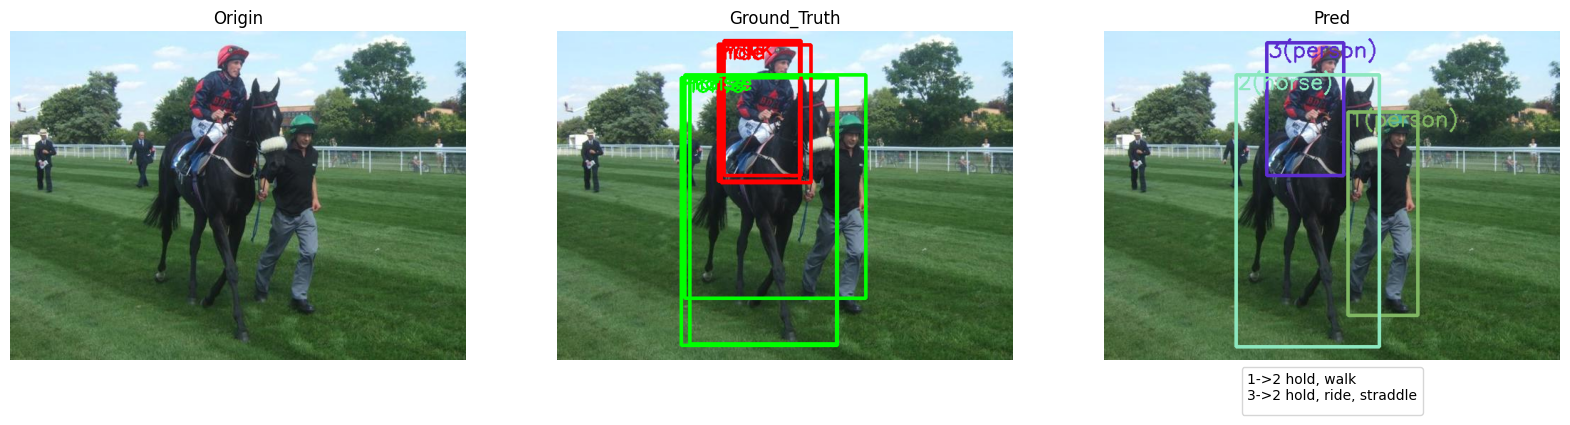

In [13]:
HOI(2)